# Inception v4 (Exercise 11-1)
Exercise Sung Kim lesson 11: Advanced CNN<br>
https://arxiv.org/abs/1602.07261<br>
Secret Sauce: `git@github.com:Cadene/pretrained-models.pytorch.git`<br>
He has well defined `stride and padding`!<br>
Test with MNIST. Because it is small dataset and I have base line at 98% or more accuracy

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

device = 'cpu'

In [25]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [96]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            y_test += list(target)
            y_pred += list(pred.view_as(target))
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mtx, classes=classes, normalize=True,
                          title='Normalized confusion matrix')


# 1. Model

Stem is divided to 3 parts. `StemFront, StemMid, and StemLast`<br>
No `stride` yet since I am going to use it with `CIFAR10` **NOT** `ILSVRC-2012`

stemfront = StemFront()
for i, (data, target) in enumerate(testloader):
    output = stemfront(data)

In [131]:
class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


In [113]:
class StemFront(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 96, kernel_size=3, stride=2)

        self.maxpool = nn.MaxPool2d(3, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)        
        maxpool = self.maxpool(x)
        conv = self.conv4(x)
        outputs = [conv, maxpool]
        return torch.cat(outputs, 1)

In [114]:
class StemMid(nn.Module):
    def __init__(self):
        super().__init__()
        # LHS
        self.lconv1x1 = nn.Conv2d(160, 64, kernel_size=1, stride=1)
        self.lconv3x3 = nn.Conv2d(64, 96, kernel_size=3, stride=1)
        # RHS
        self.rconv1x1 = nn.Conv2d(160, 64, kernel_size=1, stride=1)
        self.rconv7x1 = nn.Conv2d(64, 64, kernel_size=(7, 1), stride=1, padding=(3, 0))
        self.rconv1x7 = nn.Conv2d(64, 64, kernel_size=(1, 7), stride=1, padding=(0, 3))
        self.rconv3x3 = nn.Conv2d(64, 96, kernel_size=(3, 3), stride=1)

    def forward(self, x):
        lhs = self.lconv1x1(x)
        lhs = self.lconv3x3(lhs)
        
        rhs = self.rconv1x1(x)
        rhs = self.rconv7x1(rhs)
        rhs = self.rconv1x7(rhs)
        rhs = self.rconv3x3(rhs)
        outputs = [lhs, rhs]
        return torch.cat(outputs, 1)

In [115]:
class StemLast(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(192, 192, kernel_size=3, stride=2)
        self.maxpool = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        conv = self.conv(x)
        maxpool = self.maxpool(x)
        outputs = [conv, maxpool]
        return torch.cat(outputs, 1)

In [116]:
class Stem(nn.Module):
    def __init__(self):
        super().__init__()
        self.front = StemFront()
        self.mid = StemMid()
        self.last = StemLast()
        
    def forward(self, x):
        x = self.front(x)
        x = self.mid(x)
        x = self.last(x)
        return x

In [154]:
class InceptionA(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1x1_96 = nn.Conv2d(384, 96, kernel_size=1, stride=1)
        
        self.conv1x1_64_l2 = nn.Conv2d(384, 64, kernel_size=1, stride=1)
        self.conv3x3_96 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)
        
        self.conv1x1_64_l3 = nn.Conv2d(384, 64, kernel_size=1, stride=1)
        self.conv3x3_96_l3 = nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)
        self.conv3x3_96_l3_last = nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1)
        
        self.avg_pool = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)
        self.conv1x1 = nn.Conv2d(384, 96, kernel_size=1, stride=1)
        
        
    def forward(self, x):
        x0 = self.conv1x1_96(x)

        x1 = self.conv1x1_64_l2(x)
        x1 = self.conv3x3_96(x1)
        
        x2 = self.conv1x1_64_l3(x)
        x2 = self.conv3x3_96_l3(x2)
        x2 = self.conv3x3_96_l3_last(x2)
        
        x3 = self.avg_pool(x)
        x3 = self.conv1x1(x3)
        
        outputs = [x0, x1, x2, x3]
        return torch.cat(outputs, 1)        

In [160]:
class ReductionA(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_pool = nn.MaxPool2d(3, stride=2)
        
        self.conv3x3_1 = nn.Conv2d(384, 384, kernel_size=3, stride=2)
        
        self.conv1x1_2 = nn.Conv2d(384, 192, kernel_size=1, stride=1)
        self.conv3x3_2 = nn.Conv2d(192, 224, kernel_size=3, stride=1 , padding=1)
        self.conv3x3_last = nn.Conv2d(224, 256, kernel_size=3, stride=2)
    def forward(self, x):
        import ipdb; ipdb.set_trace()
        x0 = self.conv3x3_1(x)
        x1 = self.conv1x1_2(x)
        x1 = self.conv3x3_2(x1)
        x1 = self.conv3x3_last(x1)
        x2 = self.max_pool(x)        
        outputs = [x0, x1, x2]
        return torch.cat(outputs, 1)        

In [166]:
class Net(nn.Module):
    """Experiment relu and linear layer with as is stem"""
    def __init__(self):
        super().__init__()
        self.stem = Stem()
        self.inception_a = InceptionA()
        self.reduction_a = Reduction_A()
        self.mp = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(384, 150)
        self.fc2 = nn.Linear(150, 70)
        self.fc_last = nn.Linear(70, 10)

    def forward(self, x):
        in_size = x.size(0)
        
        x = F.relu(self.mp(self.stem(x)))
        x = self.inception_a(x)
        x = self.reduction_a(x)
        
        x = x.view(in_size, -1) # flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc_last(x))
        return F.log_softmax(x, dim=1)

class Net1(torch.nn.Module):
    """
    Normal CNN
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1) # in_channel is 1. Because it has 1 color
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        
        self.mp = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(500, 80)
        self.fc = nn.Linear(80, 10)

    def forward(self, x):
        in_size = x.size(0)
        
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        
        x = x.view(in_size, -1) # flatten the tensor
        x = F.relu(self.linear1(x))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [167]:
model = Net()

# 2. Loss & Optimizer
criterion has been absorbed to the `train and test` functions already

In [168]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [169]:
for epoch in range(1, 1 + 1):
    train(model, 'cpu', trainloader, optimizer, epoch)
    test(model, 'cpu', testloader)

RuntimeError: std::exception

# Scratch Note

In [13]:
target = torch.tensor([3, 2 ,2, 4], dtype=torch.long)
pred = torch.tensor([8,2,2,4], dtype=torch.long)

In [14]:
y_test = list(target)
y_pred = list(pred)

[[2 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 0]]


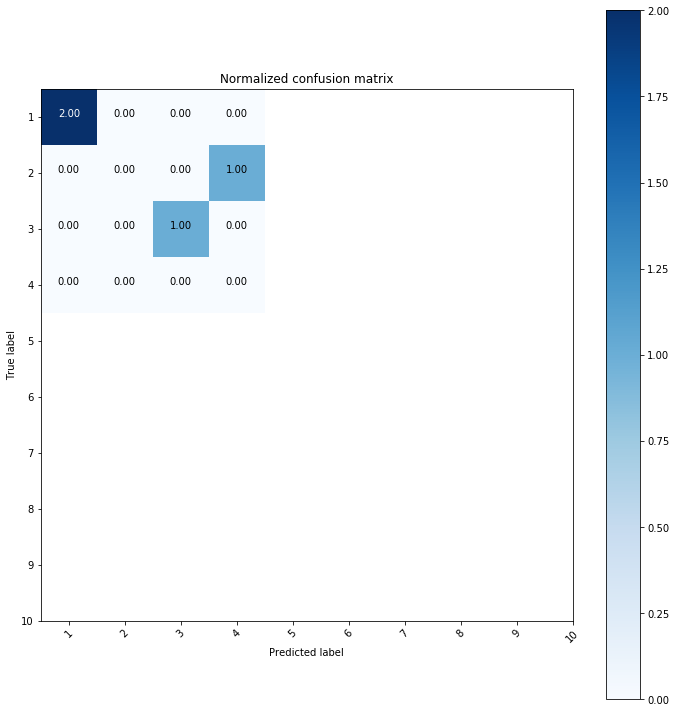

In [15]:
confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, classes=[i for i in range(1, 10 + 1)], normalize=True,
                      title='Normalized confusion matrix')
